“For the things we have to learn before we can do them, we learn by doing them.” ― Aristotle, The Nicomachean Ethics ![img](http://144ood1pir281165p42ayw0t.wpengine.netdna-cdn.com/aristotle/files/2012/12/Aristotle-Face1.jpeg)

### Decision trees & model selection

![img](https://pbs.twimg.com/media/B13n2VVCIAA0hJS.jpg)

In [1]:
import numpy as np

In [2]:
toy_data = np.load('data.npz')
X, y = toy_data['X'], toy_data['y']
print(X.shape, y.shape)

(4505, 2) (4505,)


In [3]:
# To save training time only 50% of the loaded data is used for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, shuffle=True)

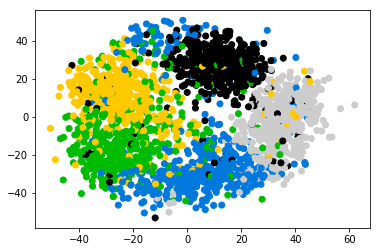

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='nipy_spectral');

# Decision trees out of the box

DecisionTreeClassifier has a number of parameters:
* max_depth : a limit on tree depth (default : no limit)
* min_samples_split : there should be at least this many samples to split further (default : 2)
* min_samples_leaf : there should be at least this many samples on one side of a split to consider it valid (default : 1).
* criterion : 'giny' or 'entropy' - split stuff over this parameter (default : giny)

In [5]:
from sklearn.tree import DecisionTreeClassifier

Probably a slightly better way of evaluating quality is by including the mean and std of the metric.

### Plot decision surface

This function takes your classifier and plots it's prediction at each point. Let's see how it works.

(this only works for two dimensions, so it is reasonable to play with the toy dataset before turning to Higgs)

In [6]:
from sklearn.metrics import accuracy_score
def plot_decision_surface(clf, X, y, plot_step = 0.2, cmap='nipy_spectral', figsize=(12,8)):
    """Plot the decision boundary of clf on X and y, visualize training points"""
    plt.figure(figsize=figsize)
    x0_grid, x1_grid = np.meshgrid(np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, plot_step),
                         np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, plot_step))
    y_pred_grid = clf.predict(np.stack([x0_grid.ravel(), x1_grid.ravel()],axis=1)).reshape(x1_grid.shape)
    plt.contourf(x0_grid, x1_grid, y_pred_grid, cmap=cmap, alpha=0.5)  
    y_pred = clf.predict(X)    
    plt.scatter(*X[y_pred==y].T,c = y[y_pred==y],
                marker='.',cmap=cmap,alpha=0.5,label='correct')
    plt.scatter(*X[y_pred!=y].T,c = y[y_pred!=y],
                marker='x',cmap=cmap,s=50,label='errors')
    plt.legend(loc='best')
    print("Accuracy = ",accuracy_score(y, y_pred))
    plt.show()

### Train quality

In [7]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=6)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Accuracy =  0.8370337477797514


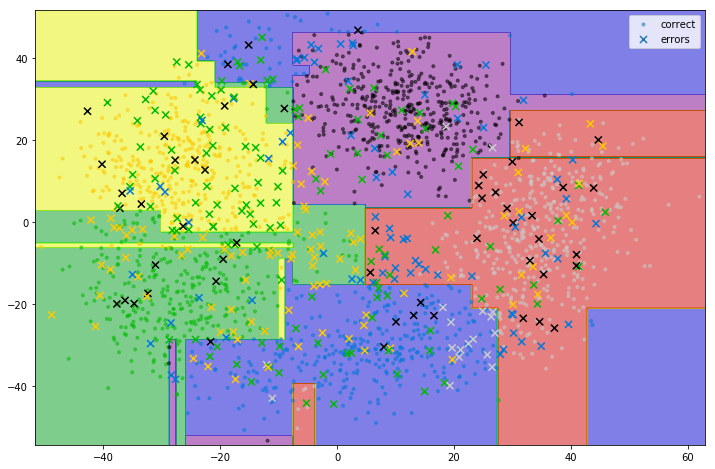

In [8]:
plot_decision_surface(tree, X_train, y_train)

In [9]:
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=11, random_state=13)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')

Accuracy =  0.8317051509769094


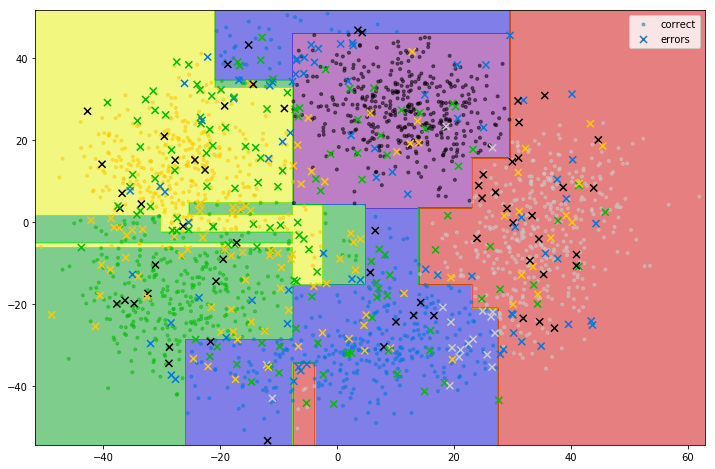

In [10]:
plot_decision_surface(tree, X_train, y_train)

### Test quality


__Before you run it:__ guess what's going to happen with test accuracy vs train accuracy judging by the train plot?

Accuracy =  0.7820683533067022


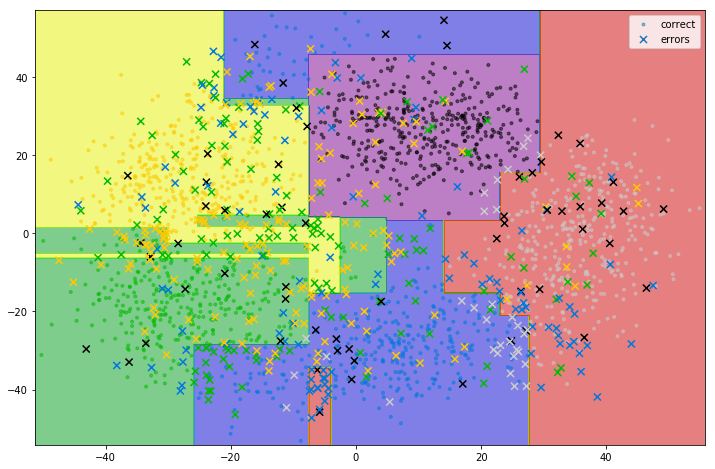

In [11]:
plot_decision_surface(tree, X_test, y_test)

```

```

```

```

```

```

```

```


### We need a better tree!

Try adjusting parameters of DecisionTreeClassifier to improve test accuracy.
 * Accuracy >= 0.72 - not bad for a start
 * Accuracy >= 0.75 - better, but not enough
 * Accuracy >= 0.77 - pretty good
 * Accuracy >= 0.78 - great! (probably the best result for a single tree)
 
Feel free to modify the DecisionTreeClassifier above instead of re-writing everything.

__Note:__ some of the parameters you can tune are under the "Decision trees out of the box" header.

## Ensembles

Let's build our own decision tree bagging and see if it works. Implement __`BagOfTrees`__ class below

In [12]:
from itertools import cycle

In [13]:
class BagOfTrees:
    
    def __init__(self, n_estimators=10, **kwargs):
        self.trees = []
        for i in range(n_estimators):
            self.trees.append(DecisionTreeClassifier(**kwargs))
            
    def fit(self, X, y):
        self.classes_ = set()
        for tree in self.trees:
            ix = np.random.randint(0, len(X), len(X))
            X_sample, y_sample = X[ix], y[ix]
            tree.fit(X_sample, y_sample)
            self.classes_.update(tree.classes_)
        self.classes_ = np.array(list(self.classes_))
        # TODO(kazeevn) lift the requirement
        assert(self.classes_[0]) == 0
        assert((np.diff(self.classes_) == 1).all())
        return self

    def predict_proba(self, X):
        trees = self.trees
        predictions = np.zeros((X.shape[0], len(self.classes_)))
        
        for tree in trees:
            tree_predictions = np.zeros((len(X), len(self.classes_)))
            tree_predictions[:, tree.classes_] = tree.predict_proba(X)
            predictions += tree_predictions
        
        predictions /= len(trees)
        return predictions
    
    def predict(self, X):
        predictions = self.predict_proba(X)
        return np.argmax(predictions, axis=1)

In [14]:
np.all(np.argmax(tree.predict_proba(X), axis=1) == tree.predict(X))

True

In [15]:
model = BagOfTrees(n_estimators=100, min_samples_leaf=5)
model.fit(X_train,y_train)

In [16]:
print('\n'.join(map(str, model.trees[:2])))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [17]:
pred = model.predict(X_test[::100])
print("predictions:", pred)
assert isinstance(pred, np.ndarray), "prediction must be a numpy array"
assert str(pred.dtype).startswith('int'), "prediction dtype must be integer (int32/int64)"
assert pred.ndim == 1, "prediction must be a vector (1-dimensional)"
assert len(pred) == len(X_test[::100]), "must predict exactly one answer for each input (expected length %i, got %i)" % (len(X_test[::100]), len(pred))
assert any(model.trees[0].predict(X_train) != model.trees[1].predict(X_train)), "All trees are the same. Did you forget to train each tree on a random part of data?"

predictions: [2 2 0 2 2 4 3 2 3 2 0 1 3 4 2 3 2 4 2 4 4 4 4]


In [18]:
for i, tree in enumerate(model.trees[:5]):
    print("tree %i individual accuracy = %.5f"%(i+1, accuracy_score(y_test,tree.predict(X_test))))

tree 1 individual accuracy = 0.74390
tree 2 individual accuracy = 0.75189
tree 3 individual accuracy = 0.73680
tree 4 individual accuracy = 0.73591
tree 5 individual accuracy = 0.73280


In [19]:
print("Ensemble accuracy:", accuracy_score(model.predict(X_test), y_test)) # should be >= 0.79

Ensemble accuracy: 0.7958277851753218


Accuracy =  0.7958277851753218


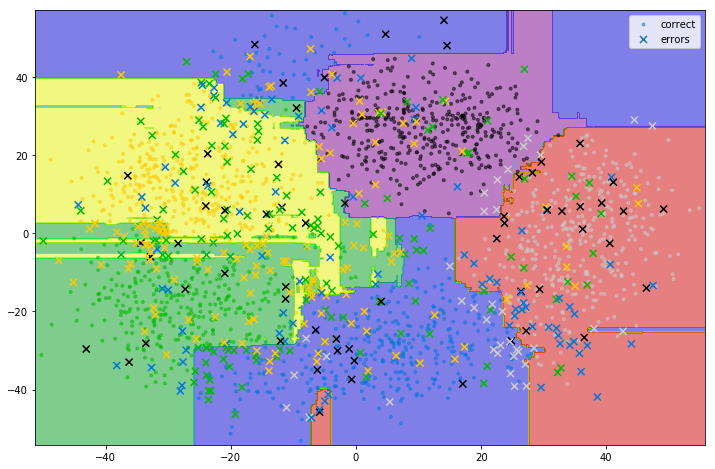

In [20]:
plot_decision_surface(model, X_test, y_test)

```

```

```

```

```

```

```

```

```

```

```

```

### Using  existing ensembles : Random Forest

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples and while split in that tree is chosen among a subset of features. This leads to a slightly better performance.

__Note:__ try re-running your code a few times and see what happens to accuracy.

In [21]:
# scikit-learn spams numpy warnings
# if you feel like digging into the scikit-learn/numpy internals, feel free to comment this out
# https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [22]:
from sklearn.ensemble import BaggingClassifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

Accuracy =  0.8020417221482468


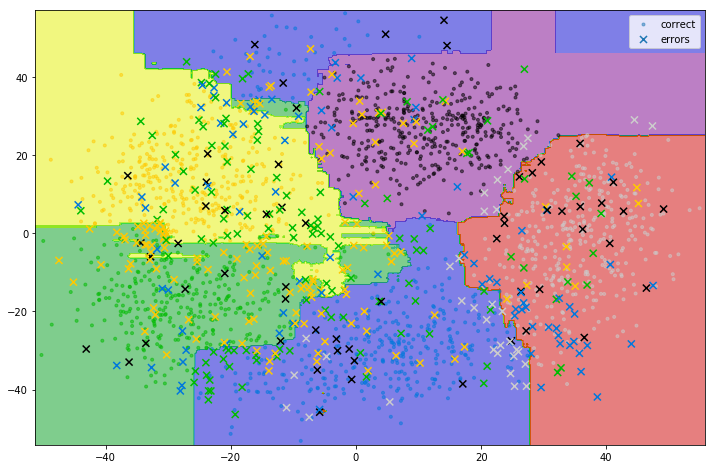

In [24]:
# Task: create and fit a random forest with 100 estimators and at least 5 samples per leaf

model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)

model.fit(X_train, y_train)

plot_decision_surface(model, X_test, y_test)

In [25]:
acc = accuracy_score(model.predict(X_test), y_test)
assert acc >= 0.792, "acc is below 0.792. Try changing random forest hyperparameters."

### Using existing ensembles : Gradient Boosting

__Note:__ if you don't have xgboost, use from sklearn.ensemble import GradientBoostingClassifier as XGBClassifier

In [26]:
from xgboost import XGBClassifier

n_estimators =  1
Accuracy =  0.7913892587660897


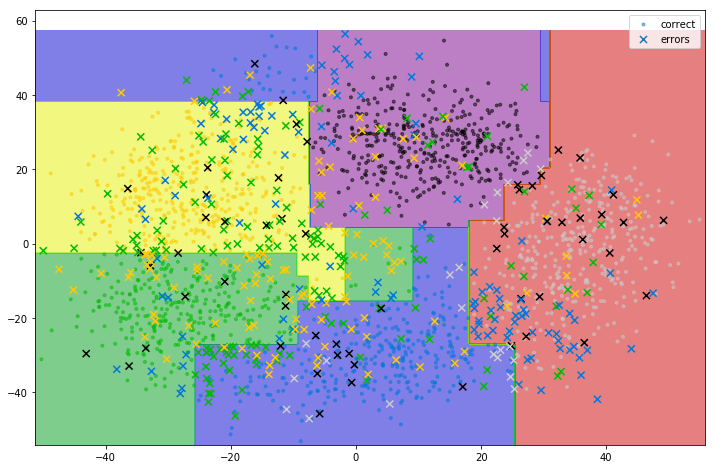

n_estimators =  2
Accuracy =  0.787838437638704


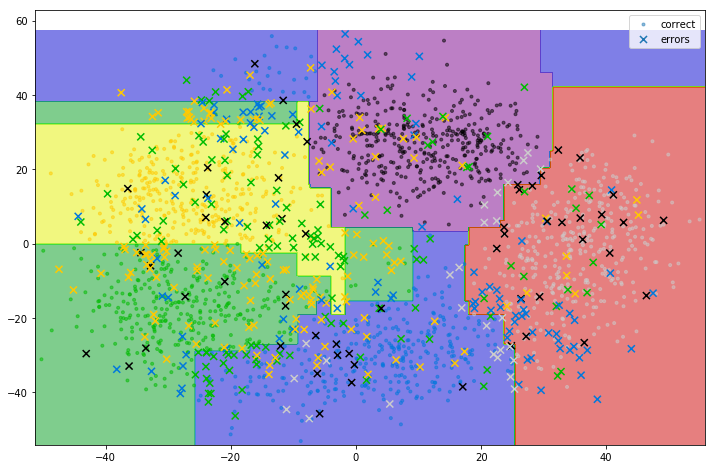

n_estimators =  3
Accuracy =  0.800266311584554


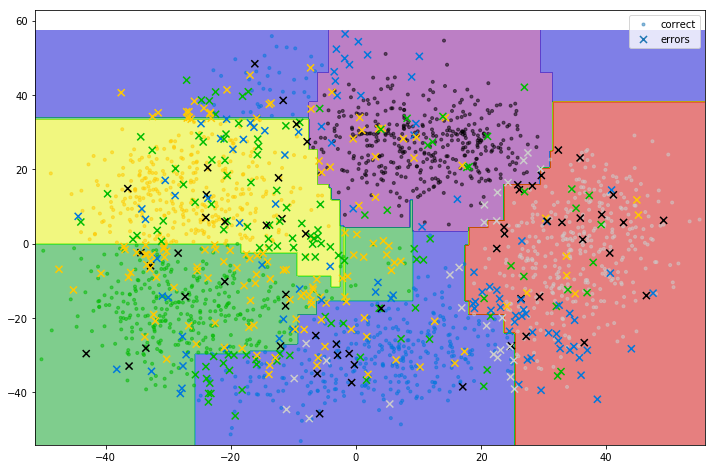

n_estimators =  4
Accuracy =  0.8042609853528628


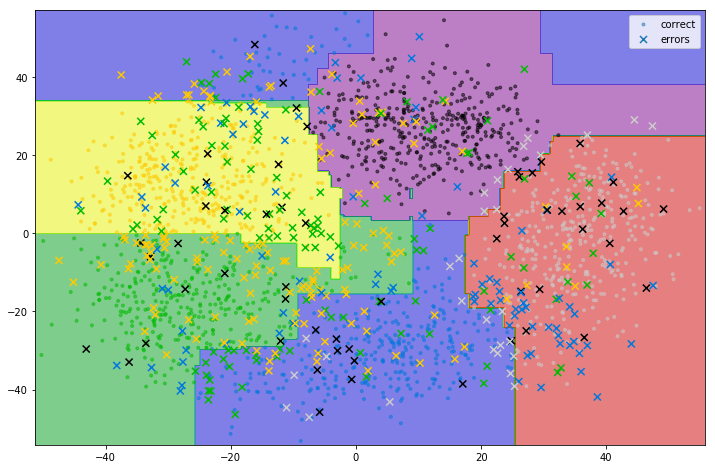

n_estimators =  5
Accuracy =  0.8055925432756325


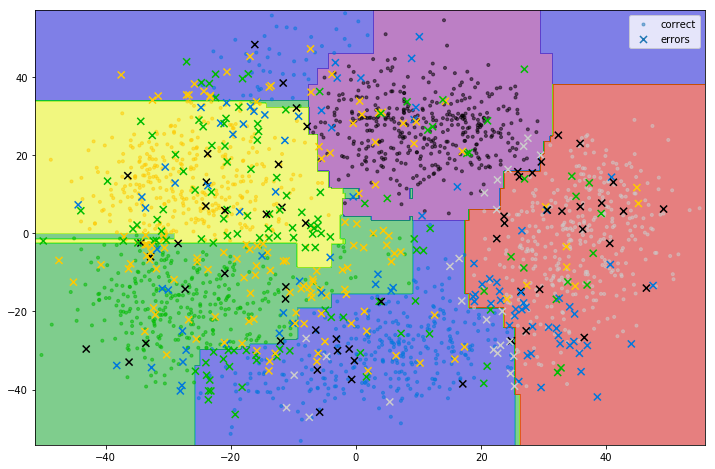

n_estimators =  6
Accuracy =  0.8060363959165557


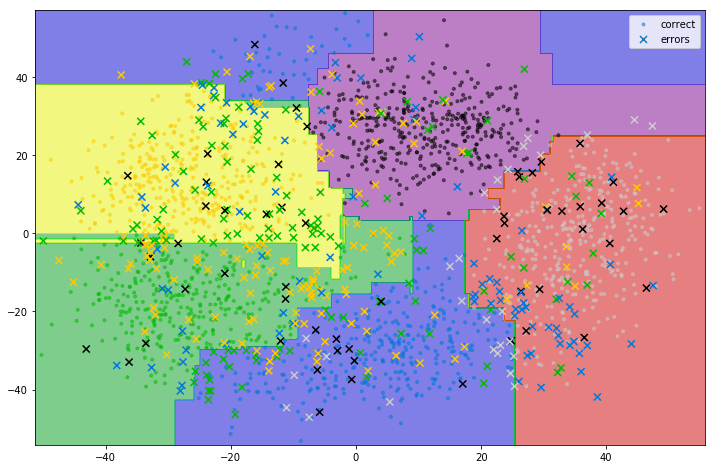

n_estimators =  7
Accuracy =  0.8064802485574789


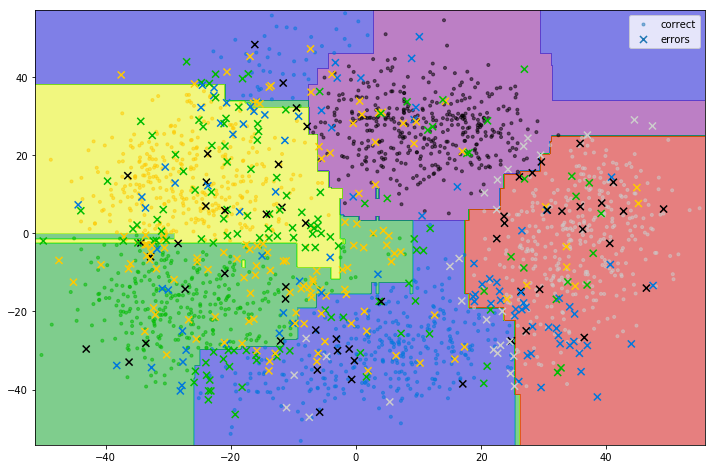

n_estimators =  8
Accuracy =  0.8073679538393254


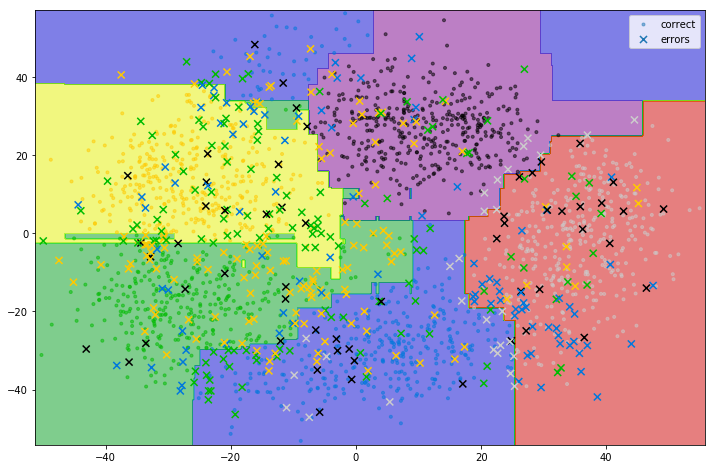

n_estimators =  9
Accuracy =  0.8038171327119397


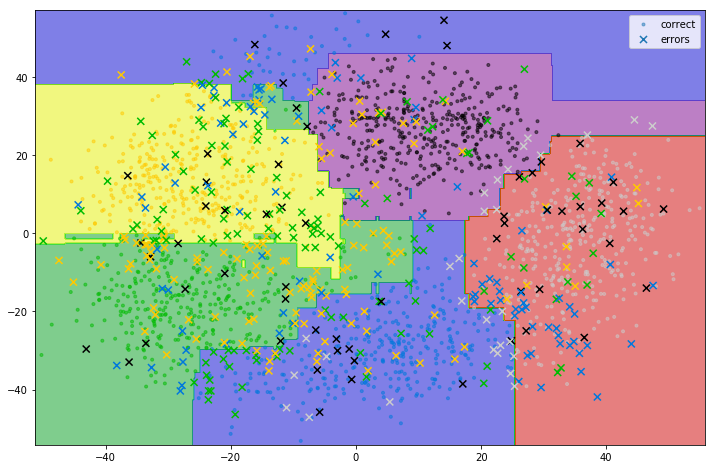

In [27]:
for n_estimators in range(1,10):
    model = XGBClassifier(max_depth=3, learning_rate=0.5, n_estimators=n_estimators)
    model.fit(X_train, y_train)

    print("n_estimators = ", n_estimators)
    plot_decision_surface(model, X_test, y_test)

### HIGGS data (100K subsample)

In [28]:
data = np.genfromtxt("/mnt/mlhep2018/datasets/HIGGS.csv", 
                     delimiter=",", dtype=np.float32, max_rows=100000)
X, y = data[:, 1:], data[:, 0]

print(X.shape, y.shape)

(100000, 28) (100000,)


In [29]:
from sklearn.model_selection import cross_val_score

dt_cv = cross_val_score(DecisionTreeClassifier(max_depth=4),
                X, y, 
                cv=4, n_jobs=4, scoring="roc_auc")
print(dt_cv.mean(), dt_cv.std())

0.7098753803786053 0.002659825283465728


### Grid search

__Bonus Quest:__ Find optimal parameters for GradientBoostingClassifier using grid search.

This time please use a special validation set (i.e. don't make decisions based on X_test, y_test).

You can implement a loop that searches over max_depth and learning_rate for a __fixed n_estmators=100__.

In [30]:
from sklearn.model_selection import GridSearchCV, KFold

In [31]:
model = XGBClassifier()
params = {'max_depth': [1, 2, 3, 4, 5, 6], 
          'n_estimators': [2, 4, 8, 16, 32],
         }

gcv = GridSearchCV(n_jobs=4, cv=KFold(4), estimator=model, param_grid=params)
gcv.fit(X, y)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6], 'n_estimators': [2, 4, 8, 16, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
gcv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=32,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
dt_cv = cross_val_score(gcv.best_estimator_,
                X, y, 
                cv=4, n_jobs=4, scoring="roc_auc")
print(dt_cv.mean(), dt_cv.std())

0.7928313991963627 0.0033268289868763827


```

```

```

```

```

```

```

```

```

```

```

```

```

```

### Automatic ML: model selection

While grid search is reasonably good for parameter optimization, it oftentimes spends a lot of times exploring hopeless regions. There are other approaches to finding optimal model that can result in drastically smaller cpu time.

The first approach is __bayesian optimization__, whos main idea is to model probability density function of a score (e.g. accuracy) at every point and explore points that are most likely to give optimal solution. The "wilingness to try this point" is called the acquisition function.

The most popular bayesian optimization methods are __gaussian process optimization(GP)__ and __tree-structured parzen estimators (TPE)__, differning mainly in the way they estimate the distributions. 

This time we're gonna see TPE in action using the [modelgym](https://github.com/yandexdataschool/modelgym) package.

_warning: the package is still in early development, some things may suddenly break down_

In [ ]:
from modelgym.models import CtBClassifier # CatBoost gradient boosting
from modelgym.utils import XYCDataset, ModelSpace
from modelgym.metrics import Accuracy

In [35]:
from modelgym.trainers import TpeTrainer

trainer = TpeTrainer(
    [ModelSpace(CtBClassifier, {'iterations':25})]) #you can add more models here...

trainer.crossval_optimize_params(Accuracy(), XYCDataset(X_train, y_train), cv=3)

In [36]:
trainer.get_best_results()

{'CtBClassifier': {'result': {'loss': -0.3721148098831188,
   'metric_cv_results': [{'accuracy': 0.3754993342210386},
    {'accuracy': 0.36617842876165113},
    {'accuracy': 0.37466666666666665}],
   'params': {'bagging_temperature': 1.5100131116101303,
    'depth': 10,
    'iterations': 25,
    'l2_leaf_reg': 10,
    'leaf_estimation_method': 'Newton',
    'learning_rate': 0.20701881105352798,
    'rsm': 0.769687014900404},
   'status': 'ok',
   'loss_variance': 0.004211397189256329},
  'model_space': <modelgym.utils.model_space.ModelSpace at 0x7fb54b043be0>}}

In [37]:
cbc = CtBClassifier(trainer.get_best_results()['CtBClassifier']['result']['params']).fit(XYCDataset(X_train, y_train))

An alternative approach here is __stochastic optimization__. If bayesian optimization is like a scalpel that cuts precisely where it should, stochastic optimization is a shotgun that shoots a bunch of pellets and sees which of them are most successful.

We're gonna see this in action with the help of [tpot](https://github.com/EpistasisLab/tpot/) - a library for hyperparameter optimization via genetic programming.

In [38]:
from tpot import TPOTClassifier

trainer = TPOTClassifier(
    population_size=50, generations=10, # genetic algorithm params
                     cv=3,                               # 3-fold cross-validation
                     n_jobs=4,                           # parallel processes
                     max_eval_time_mins = 0.5,            # model should train in under 30 seconds
                     verbosity=2,
                    )

In [39]:
trainer.fit(X_train, y_train)

Optimization Progress:  18%|█▊        | 100/550 [00:50<10:51,  1.45s/pipeline]

Generation 1 - Current best internal CV score: 0.816164618652103


Optimization Progress:  27%|██▋       | 150/550 [01:31<27:06,  4.07s/pipeline]

Generation 2 - Current best internal CV score: 0.816164618652103


Optimization Progress:  36%|███▋      | 200/550 [01:53<08:40,  1.49s/pipeline]

Generation 3 - Current best internal CV score: 0.8179566313953047


Optimization Progress:  45%|████▌     | 250/550 [02:20<08:03,  1.61s/pipeline]

Generation 4 - Current best internal CV score: 0.8179566313953047


Optimization Progress:  55%|█████▍    | 300/550 [02:51<04:12,  1.01s/pipeline]

Generation 5 - Current best internal CV score: 0.8197178291045626


Optimization Progress:  64%|██████▍   | 351/550 [03:43<10:22,  3.13s/pipeline]

Generation 6 - Current best internal CV score: 0.8197178291045626


Optimization Progress:  73%|███████▎  | 401/550 [04:07<03:19,  1.34s/pipeline]

Generation 7 - Current best internal CV score: 0.8197178291045626


Optimization Progress:  82%|████████▏ | 451/550 [04:32<02:08,  1.30s/pipeline]

Generation 8 - Current best internal CV score: 0.8197178291045626


Optimization Progress:  91%|█████████ | 501/550 [04:56<01:08,  1.40s/pipeline]

Generation 9 - Current best internal CV score: 0.8201634619031365


Generation 10 - Current best internal CV score: 0.8201634619031365

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
        crossover_rate=0.1, cv=3, disable_update_check=False,
        early_stop=None, generations=10, max_eval_time_mins=0.5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=4,
        offspring_size=50, periodic_checkpoint_folder=None,
        population_size=50, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

In [40]:
best_model = trainer.fitted_pipeline_
print("TPOT test accuracy =", accuracy_score(y_test, best_model.predict(X_test)))

TPOT test accuracy = 0.8055925432756325


In [41]:
best_model

Pipeline(memory=None,
     steps=[('extratreesclassifier', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1.0, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])